# Unadjusted Langevin Primal-Dual Algorithm (ULPDA) for TV-$\ell^2$ regularization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Copied from TP5
import numpy as np
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import torch
from utils import *
from tqdm import tqdm

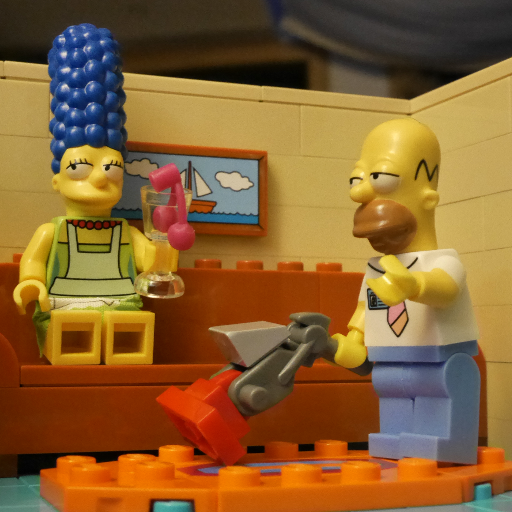

In [3]:
# Open the image
u0 = torch.tensor(plt.imread('im/simpson512.png'))
M,N, _ = u0.shape

viewimage_rgb(u0)

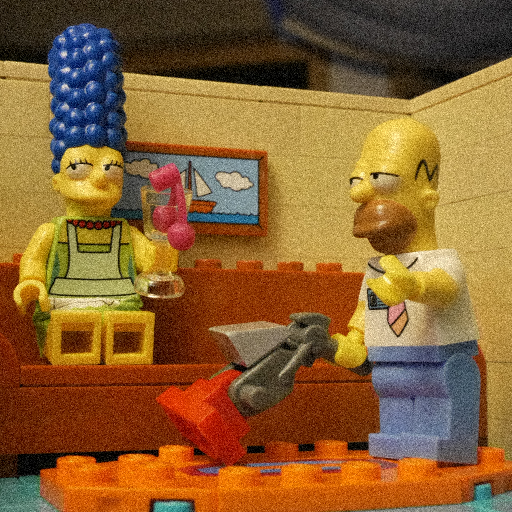

In [4]:
sigma = 15/255
z = u0 + sigma*torch.randn((M, N, 1))

viewimage_rgb(z)

In [7]:
x0 = torch.randn((M, N, 3))
p0 = torch.randn((M, N, 3, 2))
lamb = 0.15
xhat, variances = ulpda_rgb(z, x0, p0, sigma, lamb, s_k=30, tau_k=1e-3, theta_k=1, K=3000, burnin=1000)

In [15]:
variances_pixelwise = torch.sum(variances, dim=-1)

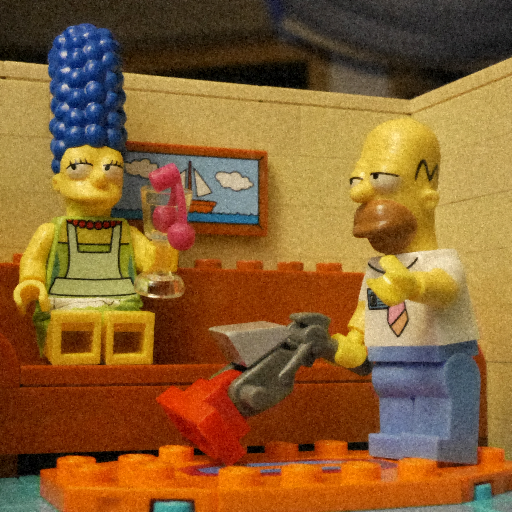

In [8]:
viewimage_rgb(xhat)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


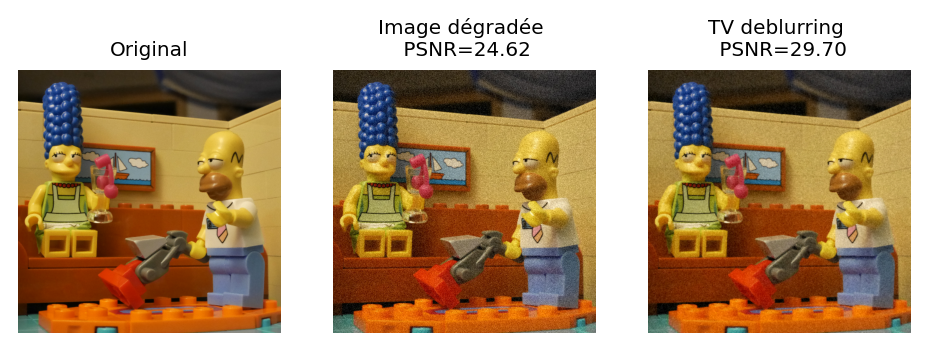

In [9]:
plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0)
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(z)
plt.title('Image dégradée \n PSNR='+str2(psnr(u0,z)),fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(xhat)
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,xhat)),fontsize=8)
plt.axis('off')
plt.show()

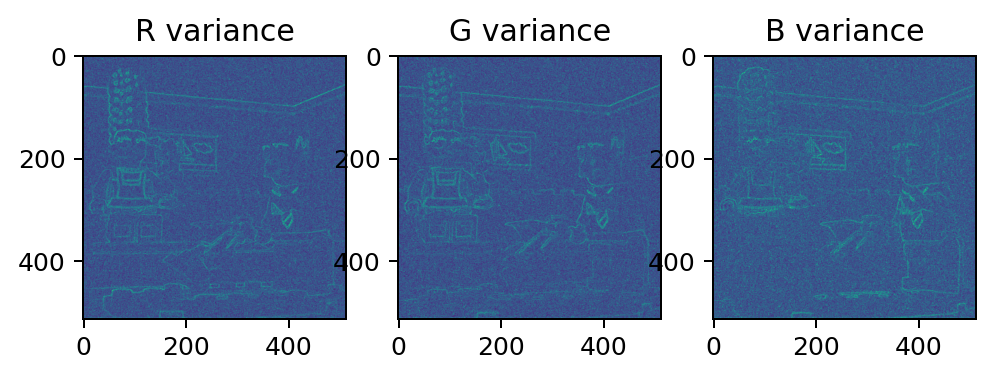

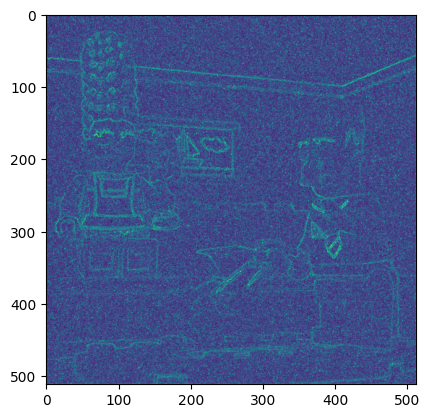

(array([1.7000e+02, 3.5270e+03, 2.3040e+04, 5.8304e+04, 6.9412e+04,
        4.9384e+04, 2.7429e+04, 1.4429e+04, 7.6210e+03, 4.1610e+03,
        2.2000e+03, 1.1540e+03, 6.1300e+02, 3.5700e+02, 1.8200e+02,
        8.6000e+01, 3.5000e+01, 2.4000e+01, 1.2000e+01, 4.0000e+00]),
 array([0.00944148, 0.00975808, 0.01007468, 0.01039128, 0.01070788,
        0.01102448, 0.01134109, 0.01165769, 0.01197429, 0.01229089,
        0.01260749, 0.01292409, 0.01324069, 0.0135573 , 0.0138739 ,
        0.0141905 , 0.0145071 , 0.0148237 , 0.0151403 , 0.01545691,
        0.01577351]),
 <BarContainer object of 20 artists>)

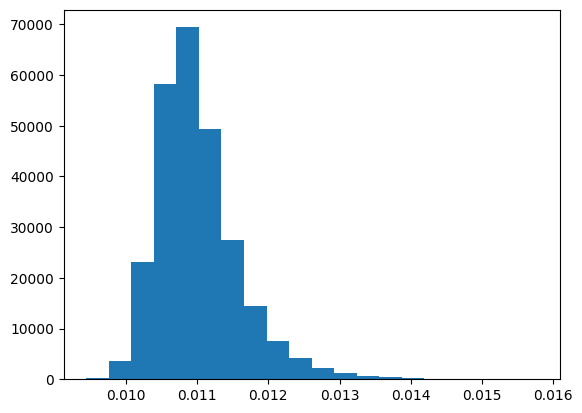

In [16]:
plt.figure(dpi=180)
plt.subplot(1, 3, 1)
plt.imshow(variances[:, :, 0])
plt.title("R variance")
plt.subplot(1, 3, 2)
plt.imshow(variances[:, :, 1])
plt.title("G variance")
plt.subplot(1, 3, 3)
plt.imshow(variances[:, :, 2])
plt.title("B variance")
plt.show()
plt.imshow(variances_pixelwise)
plt.show()
plt.hist(variances_pixelwise.flatten(), bins=20)

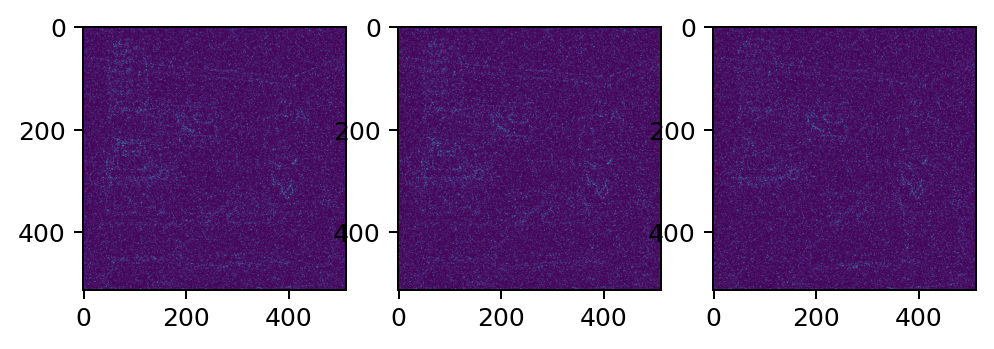

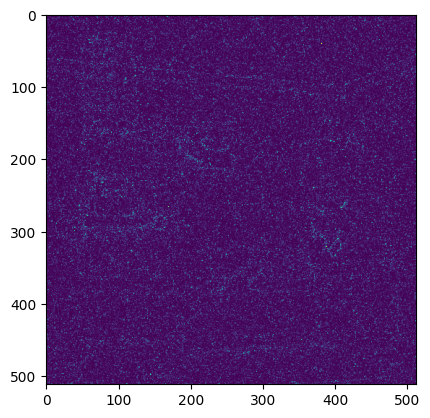

In [18]:
errors = (xhat-u0)**2
errors_pixelwise = torch.sum(errors, dim=-1)
plt.figure(dpi=180)
plt.subplot(1, 3, 1)
plt.imshow(errors[:, :, 0], vmin=0, vmax=0.02)
plt.subplot(1, 3, 2)
plt.imshow(errors[:, :, 1], vmin=0, vmax=0.02)
plt.subplot(1, 3, 3)
plt.imshow(errors[:, :, 2], vmin=0, vmax=0.02)
plt.show()
plt.imshow(errors_pixelwise, vmin=0, vmax=0.06)
plt.show()

In [20]:
nbins = 100
var_max = .03
bin_step = var_max/nbins
errors_per_bin = [[] for _ in range(nbins)]
for i in range(M):
    for j in range(N):
        bin = min(nbins-1, int(variances_pixelwise[i, j]/bin_step))
        errors_per_bin[bin].append(errors_pixelwise[i, j])
for bin in range(nbins):
    errors_per_bin[bin].sort()

In [21]:
print(list(map(len, errors_per_bin)))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 754, 8146, 34240, 62815, 62527, 41690, 23572, 12774, 6953, 3911, 2142, 1160, 666, 368, 184, 124, 43, 26, 17, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/home/victor/python-venvs/mva/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/victor/python-venvs/mva/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


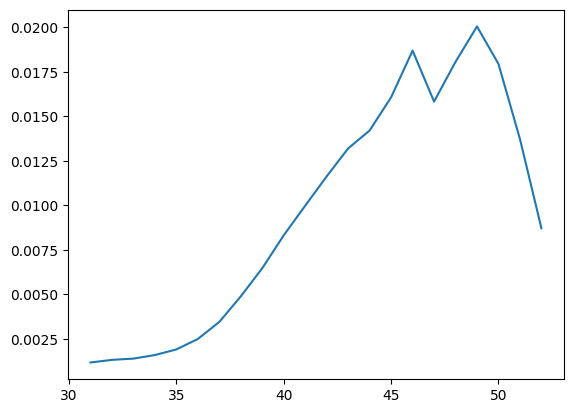

In [22]:
plt.plot(list(map(np.average, errors_per_bin)))

# Training on BSDS dataset

In [23]:
import os

In [25]:
s = []
that = []
sigma = 15/255
lamb = 0.05
n_train_imgs = 50

for f in tqdm(os.listdir("data/train")[:n_train_imgs]):
    if not f.endswith(".png"):
        continue
    u0 = torch.tensor(plt.imread(os.path.join("data/train", f)))
    M, N, _ = u0.size()
    z = u0 + sigma*torch.randn((M, N, 1))
    x0 = torch.randn((M, N, 3))
    p0 = torch.randn((M, N, 3, 2))
    xhat, variances = ulpda_rgb(z, x0, p0, sigma, lamb, s_k=30, tau_k=1e-3, theta_k=1, K=3000, burnin=1000)
    variances_pixelwise = torch.sum(variances, dim=-1)
    err = (xhat-u0)**2
    err_pixelwise = torch.sum(err, dim=-1)
    s.extend(err_pixelwise.flatten().tolist())
    that.extend(variances_pixelwise.flatten().tolist())

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [17:11<00:00, 20.63s/it]


In [26]:
np.save("s_rgb.npy", np.array(s))
np.save("that_rgb.npy", np.array(that))

In [55]:
np.min(that), np.min(s)

(0.0008494299836456776, 0.0)

/tmp/ipykernel_5961/2658126556.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(hist.T), origin='lower', extent=(that_edges[0], that_edges[-1], s_edges[0], s_edges[-1]), aspect="auto")


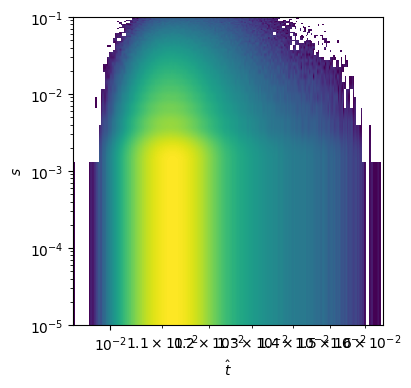

In [27]:
hist, that_edges, s_edges = np.histogram2d(that, s, bins=200)
plt.figure(figsize=(4, 4))
plt.imshow(np.log10(hist.T), origin='lower', extent=(that_edges[0], that_edges[-1], s_edges[0], s_edges[-1]), aspect="auto")
plt.xscale("log")
plt.xlabel("$\\hat{t}$")
plt.yscale("log")
plt.ylabel("$s$")
plt.ylim(1e-5, 1e-1)
plt.show()

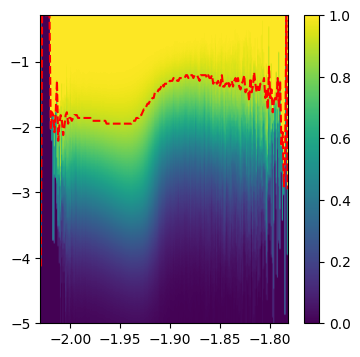

In [28]:
hist, that_edges, s_edges = np.histogram2d(np.log10(that), np.log10(np.array(s)+1e-10), bins=200)
cumhist = np.cumsum(hist, axis=1)
cumhist /= np.where(cumhist[:, -1, None] == 0.0, 1.0, cumhist[:, -1, None])
quantiles = np.zeros(len(that_edges)-1)
for i in range(len(that_edges)-1):
    quantiles[i] = s_edges[np.searchsorted(cumhist[i], .9)]
plt.figure(figsize=(4, 4))
plt.imshow(cumhist.T, origin="lower", extent=(that_edges[0], that_edges[-1], s_edges[0], s_edges[-1]), aspect="auto")
plt.colorbar()
plt.xlim(that_edges[0], that_edges[-1])
plt.ylim(-5.0, s_edges[-1])
plt.plot((that_edges[:-1] + that_edges[1:])/2, quantiles, color='red', linestyle="dashed")
plt.show()

In [30]:
nbins = 100
var_min = np.min(that)
var_max = np.max(that)
bin_step = (var_max-var_min)/nbins
errors_per_bin = [[] for _ in range(nbins)]
for i in range(len(that)):
    bin = min(nbins-1, int((that[i]-var_min)/bin_step))
    errors_per_bin[bin].append(s[i])
for bin in range(nbins):
    errors_per_bin[bin].sort()

# Testing on images

In [41]:
import math

def test_image(path, q=0.9):
    u0 = torch.tensor(plt.imread(path))
    M, N, _ = u0.size()
    z = u0 + sigma*torch.randn((M, N, 1))
    xhat, variances = ulpda_rgb(z, torch.randn((M, N, 3)), torch.randn((M, N, 3, 2)), sigma, lamb, s_k=30, tau_k=1e-3, theta_k=1, K=3000, burnin=1000)
    variances_pixelwise = torch.sum(variances, dim=-1)
    estimated_errors = torch.zeros((M, N))
    for i in range(M):
        for j in range(N):
            bin = max(0, min(nbins-1, int((variances_pixelwise[i, j]-var_min)/bin_step)))
            quantile = math.ceil(q*(1+1/len(errors_per_bin[bin]))*len(errors_per_bin[bin]))-1
            quantile = min(len(errors_per_bin[bin])-1, max(0, quantile))
            estimated_errors[i, j] = errors_per_bin[bin][quantile]

    errors = (xhat - u0)**2
    errors_pixelwise = torch.sum(errors, dim=-1)
    
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 5, 1)
    plt.imshow(u0)
    plt.title("Ground truth")
    plt.subplot(1, 5, 2)
    plt.imshow(z)
    plt.title("Corrupted image")
    plt.subplot(1, 5, 3)
    plt.imshow(xhat)
    plt.title("MMSE estimator")
    plt.subplot(1, 5, 4)
    plt.imshow(errors_pixelwise, vmin=0, vmax=0.06)
    plt.title("Error")
    plt.subplot(1, 5, 5)
    plt.imshow(estimated_errors, vmin=0, vmax=0.06)
    plt.title("Estimated error")
    plt.show()

    viewimage_rgb(u0)
    viewimage_rgb(z)

    coverage = torch.sum(errors_pixelwise <= estimated_errors)/torch.numel(errors_pixelwise)
    print(f"Coverage: {coverage}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


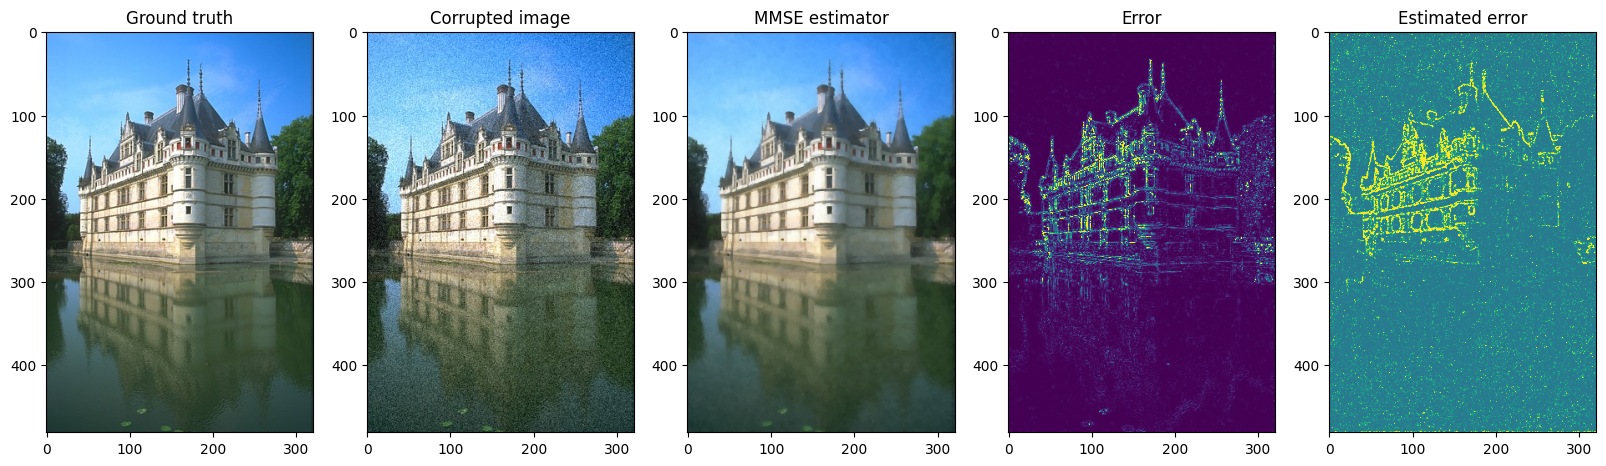

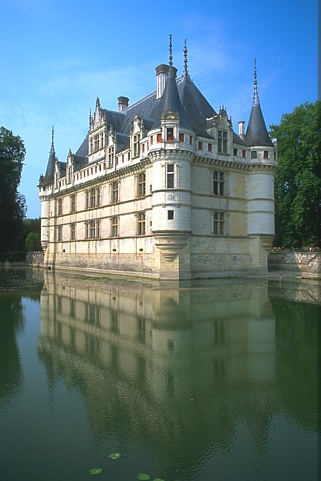

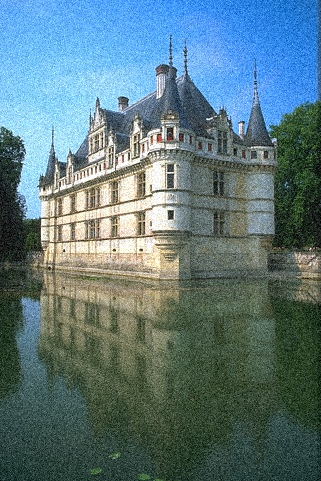

Coverage: 0.9716776609420776


In [44]:
test_image("data/test/102061.png", q=0.96)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


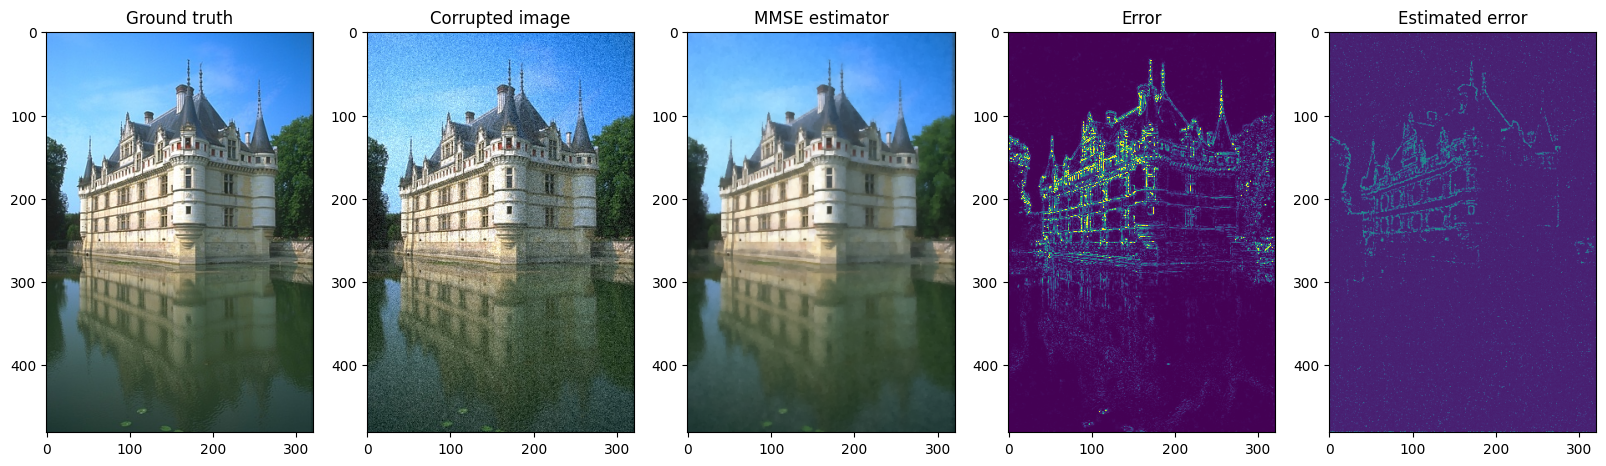

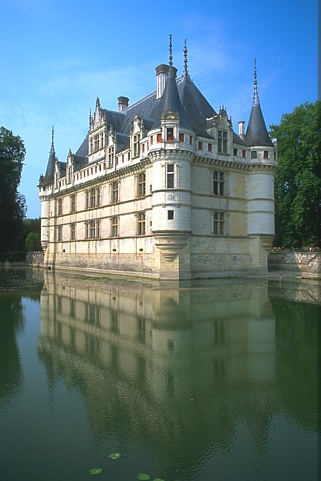

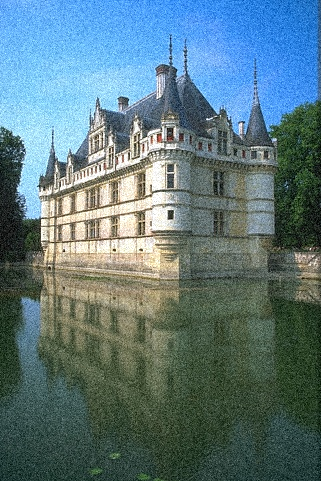

Coverage: 0.8655125498771667


In [45]:
test_image("data/test/102061.png", q=0.8)